# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from itertools import combinations_with_replacement, product

%matplotlib inline

# Data import

In [2]:
data_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/data"

## HH_S5F substitution matrix

In [3]:
hs5f = pd.read_csv(data_path + "/HS5F/HS5F_Substitution_fivemers.csv", index_col="Fivemer")
print("Number of fivemers:", len(hs5f))

Number of fivemers: 1024


# Calculate partial fivemer likelihoods

In [4]:
def create_list_of_kmers(k):

    kmers = list(product("ACGT", repeat=k))
    kmers = ["".join(x) for x in list(kmers)]
            
    return kmers


def find_matching_fivemers(fivemers, kmer, pos):
    
    matching_fivemers = []
    
    for i in fivemers:
        
        if pos == "Start":
            if i[(5-len(kmer)):] == kmer:
                matching_fivemers.append(i)
        
        elif pos == "End":
            if i[:-(5-len(kmer))] == kmer:
                matching_fivemers.append(i)
                
        elif pos == "Center":
            if i[1:4] == kmer:
                matching_fivemers.append(i)
                    
    return matching_fivemers


def create_index_name(kmer, pos):
    
    # add number of gaps according to length of kmer
    n = 5 - len(kmer)
    
    if pos == "Start":
        
        index_name = "_"*n + kmer 
        
    elif pos == "End":
        index_name = kmer + "_"*n
    
    return index_name


def calculate_position_specific_kmer_likelihood(kmers, fivemers, substitution_matrix, pos):

    for kmer in kmers:
        index_name = create_index_name(kmer, pos)
        matching_fivemers = find_matching_fivemers(fivemers, kmer, pos)
        substitution_matrix_filtered = substitution_matrix.filter(items = matching_fivemers, axis=0)
        likelihood_mean = substitution_matrix_filtered[["A", "C", "G", "T"]].mean(axis=0).rename(index_name)
        substitution_matrix = substitution_matrix._append(likelihood_mean)
    
    return substitution_matrix


def calculate_kmer_substitution_likelihoods(k, substitution_matrix):
    
    fivemers = substitution_matrix.index
    kmers = create_list_of_kmers(k)
    
    substitution_matrix = calculate_position_specific_kmer_likelihood(kmers, fivemers, substitution_matrix, "Start")
    substitution_matrix = calculate_position_specific_kmer_likelihood(kmers, fivemers, substitution_matrix, "End")

    return substitution_matrix


def calculate_aggregated_kmer_substitution_likelihoods(k, substitution_matrix, nucleotide_pos):
    
    fivemers = substitution_matrix.index
    kmers = create_list_of_kmers(k)
    
    substitution_matrix_aggregated = pd.DataFrame(columns=["A", "C", "G", "T", "A_std", "C_std", "G_std", "T_std"])
    
    for kmer in kmers:
        matching_fivemers = find_matching_fivemers(fivemers, kmer, nucleotide_pos)
        substitution_matrix_filtered = substitution_matrix.filter(items = matching_fivemers, axis=0)
        likelihood_mean = substitution_matrix_filtered[["A", "C", "G", "T"]].mean(axis=0).rename(kmer)
        likelihood_std = substitution_matrix_filtered[["A", "C", "G", "T"]].std(axis=0).rename(kmer)
        likelihood_std.index = ["A_std", "C_std", "G_std", "T_std"]
        likelihood = pd.concat([likelihood_mean, likelihood_std])
        substitution_matrix_aggregated = substitution_matrix_aggregated._append(likelihood)
    
    # add trimers as column instead of index
    substitution_matrix_aggregated = substitution_matrix_aggregated.reset_index().rename(columns={"index":"Trimer"})
    
    return substitution_matrix_aggregated


def melt_substitution_dataframe(df):
    
    # melt mean columns
    df_mean_melted = df.melt(id_vars="Trimer", value_vars=["A", "C", "G", "T"], 
        var_name=["Substitution"], value_name="Likelihood").sort_values("Trimer")
    # melt standard deviation columns
    df_std_melted = df.melt(id_vars="Trimer", value_vars=["A_std", "C_std", "G_std", "T_std"],
        var_name=["Substitution"], value_name="STD")
    # rename standard deviation columns to merge 
    df_std_melted["Substitution"] = df_std_melted["Substitution"].apply(lambda x: x[:1])
    df_melted = df_mean_melted.merge(df_std_melted, on=["Trimer", "Substitution"]).sort_values("Trimer")
    
    return df_melted


def quarter_dataframe(df):
    
    quarter = len(df) // 4
    part1, part2, part3, part4 = [df.iloc[i:i + quarter] for i in range(0, len(df), quarter)]
    
    return part1, part2, part3, part4

### Center nucleotide

In [5]:
hs5f_trimers_center = calculate_aggregated_kmer_substitution_likelihoods(3, hs5f, "Center")
print("Number of trimers:", len(hs5f_trimers_center))
hs5f_trimers_center_melted = melt_substitution_dataframe(hs5f_trimers_center)
hs5f_trimers_center_melted[:5]

Number of trimers: 64


,Trimer,Substitution,Likelihood,STD
0,AAA,A,0.000000,0.000000
1,AAA,G,0.456346,0.096472
2,AAA,C,0.359430,0.107570
3,AAA,T,0.184224,0.077067
4,AAC,C,0.282313,0.075004


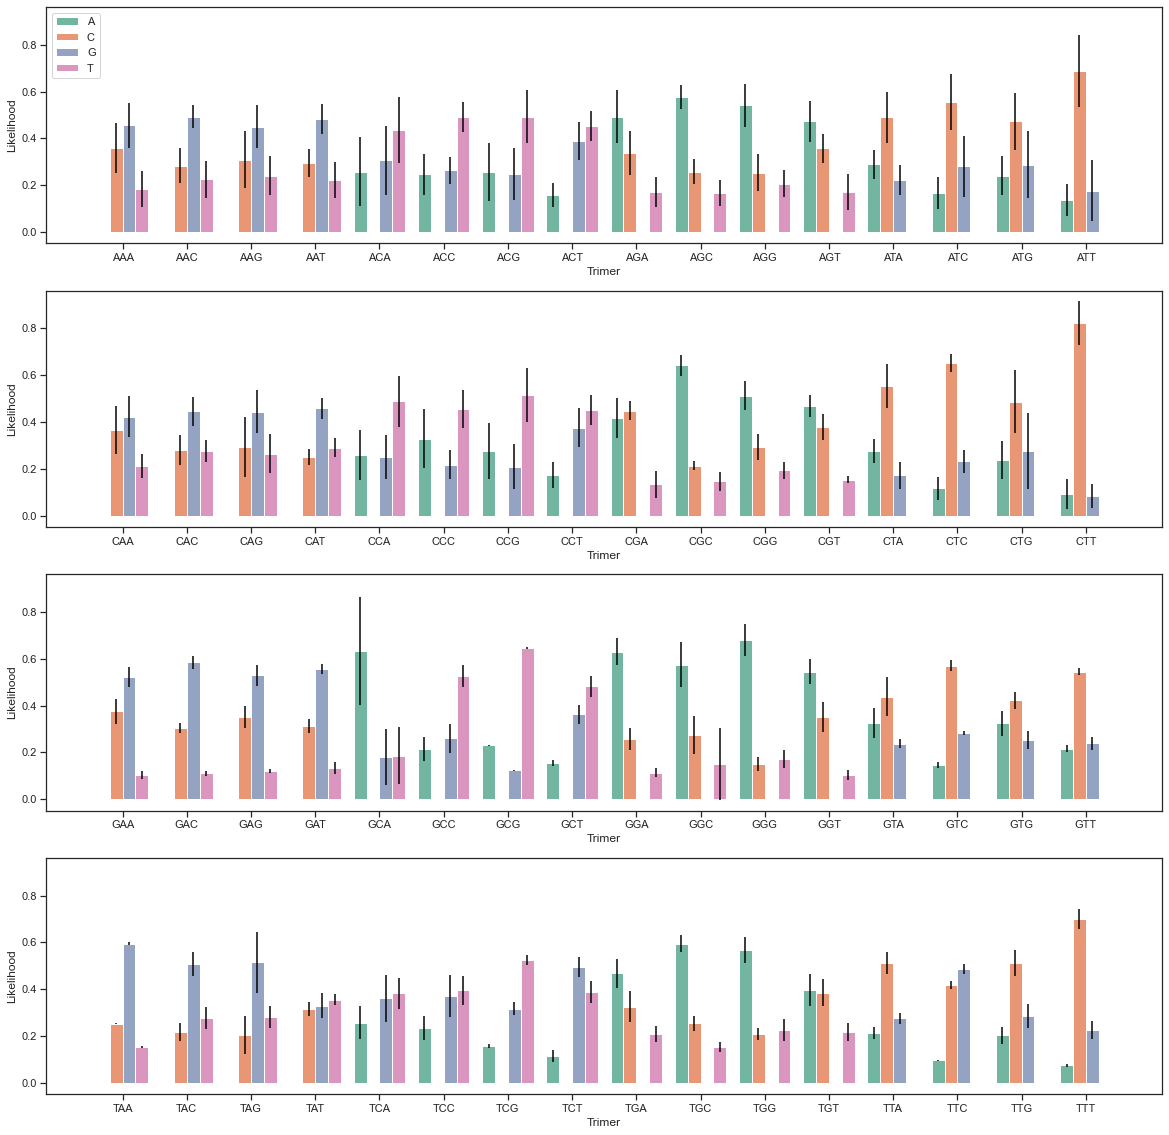

In [6]:
sns.set(style=("ticks"), font_scale=1, palette="Set2")
fig, ax = plt.subplots(4, 1, figsize=(20,20), sharey=True)

for i, df in enumerate(quarter_dataframe(hs5f_trimers_center_melted)):
    
    # dataframe must be sorted first by hue, then by x column to correctly plot errorbars on top of bars
    data = df.sort_values(["Substitution", "Trimer"])
    if i == 0:
        sns.barplot(data=data, x="Trimer", y="Likelihood", hue="Substitution", ax=ax[i])
        ax[i].legend(loc="upper left")
    else:
        sns.barplot(data=data, x="Trimer", y="Likelihood", hue="Substitution", legend=False, ax=ax[i])

    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax[i].patches]
    y_coords = [p.get_height() for p in ax[i].patches]
    ax[i].errorbar(x=x_coords[:64], y=y_coords[:64], yerr=data["STD"], fmt="none", c="k")
    
    plt.savefig(os.path.dirname(os.path.dirname(os.getcwd())) + "/figs/Aggregated_trimer_substitution_center.png", dpi=300, 
        transparent=True, bbox_inches="tight")

### Start nucleotide

In [7]:
hs5f_trimers_start = calculate_aggregated_kmer_substitution_likelihoods(3, hs5f, "Start")
print("Number of trimers:", len(hs5f_trimers_start))
hs5f_trimers_start_melted = melt_substitution_dataframe(hs5f_trimers_start)
hs5f_trimers_start_melted[:5]

Number of trimers: 64


,Trimer,Substitution,Likelihood,STD
0,AAA,A,0.000000,0.000000
1,AAA,G,0.537000,0.073281
2,AAA,C,0.305213,0.060726
3,AAA,T,0.157786,0.042071
4,AAC,C,0.313122,0.058611


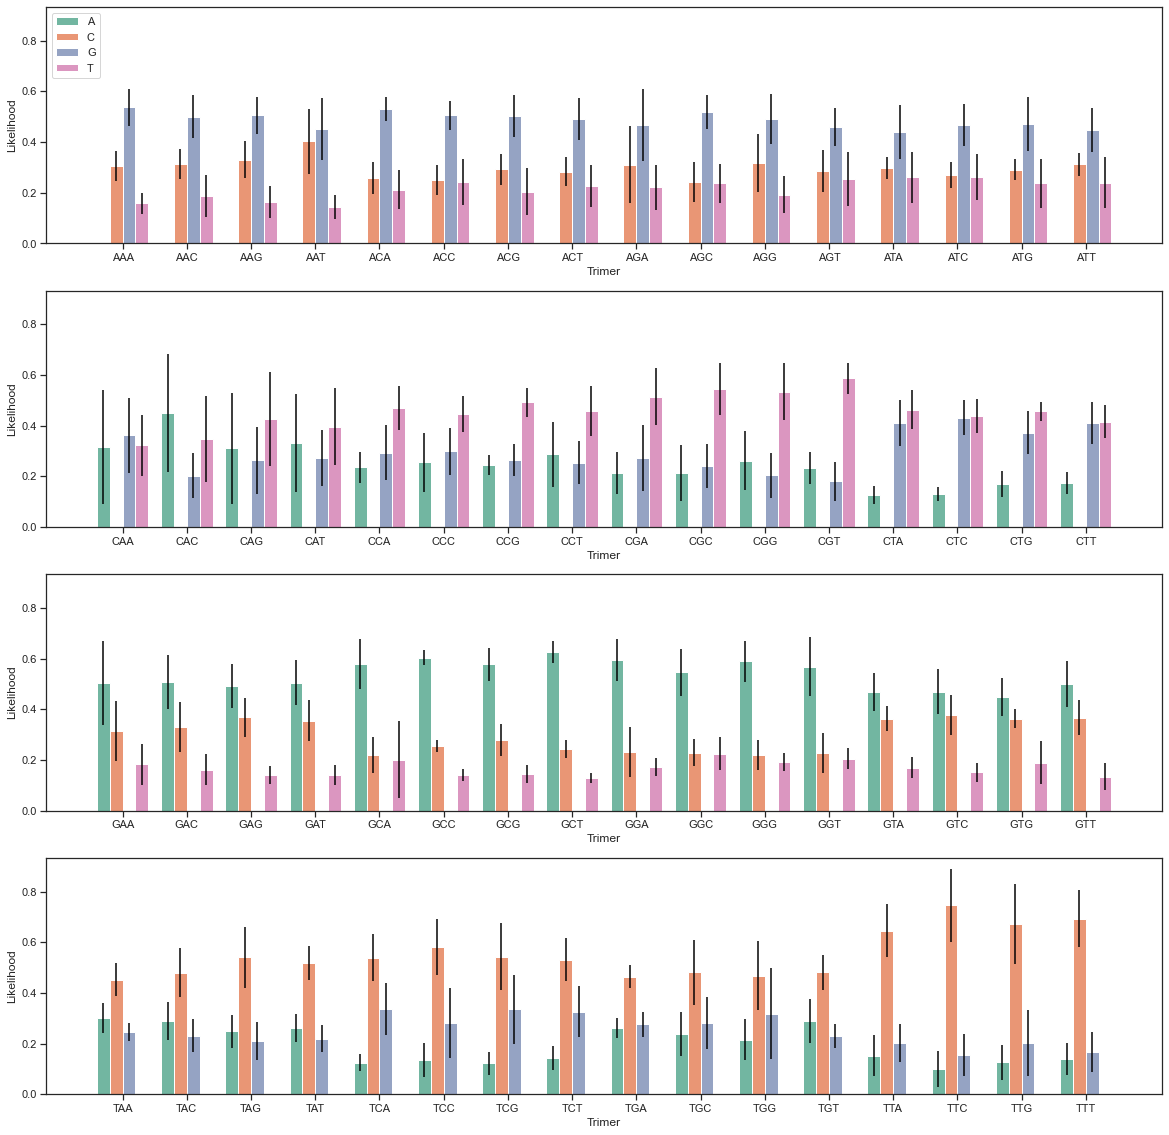

In [8]:
sns.set(style=("ticks"), font_scale=1, palette="Set2")
fig, ax = plt.subplots(4, 1, figsize=(20,20), sharey=True)

for i, df in enumerate(quarter_dataframe(hs5f_trimers_start_melted)):
    
    # dataframe must be sorted first by hue, then by x column to correctly plot errorbars on top of bars
    data = df.sort_values(["Substitution", "Trimer"])
    if i == 0:
        sns.barplot(data=data, x="Trimer", y="Likelihood", hue="Substitution", ax=ax[i])
        ax[i].legend(loc="upper left")
    else:
        sns.barplot(data=data, x="Trimer", y="Likelihood", hue="Substitution", legend=False, ax=ax[i])

    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax[i].patches]
    y_coords = [p.get_height() for p in ax[i].patches]
    ax[i].errorbar(x=x_coords[:64], y=y_coords[:64], yerr=data["STD"], fmt="none", c="k")
    
    plt.savefig(os.path.dirname(os.path.dirname(os.getcwd())) + "/figs/Aggregated_trimer_substitution_start.png", dpi=300, 
        transparent=True, bbox_inches="tight")

### End nucleotide

In [9]:
hs5f_trimers_end = calculate_aggregated_kmer_substitution_likelihoods(3, hs5f, "End")
print("Number of trimers:", len(hs5f_trimers_end))
hs5f_trimers_end_melted = melt_substitution_dataframe(hs5f_trimers_end)
hs5f_trimers_end_melted[:5]

Number of trimers: 64


,Trimer,Substitution,Likelihood,STD
0,AAA,A,0.000000,0.000000
1,AAA,G,0.456025,0.077834
2,AAA,C,0.273937,0.106324
3,AAA,T,0.270038,0.073289
4,AAC,C,0.000000,0.000000


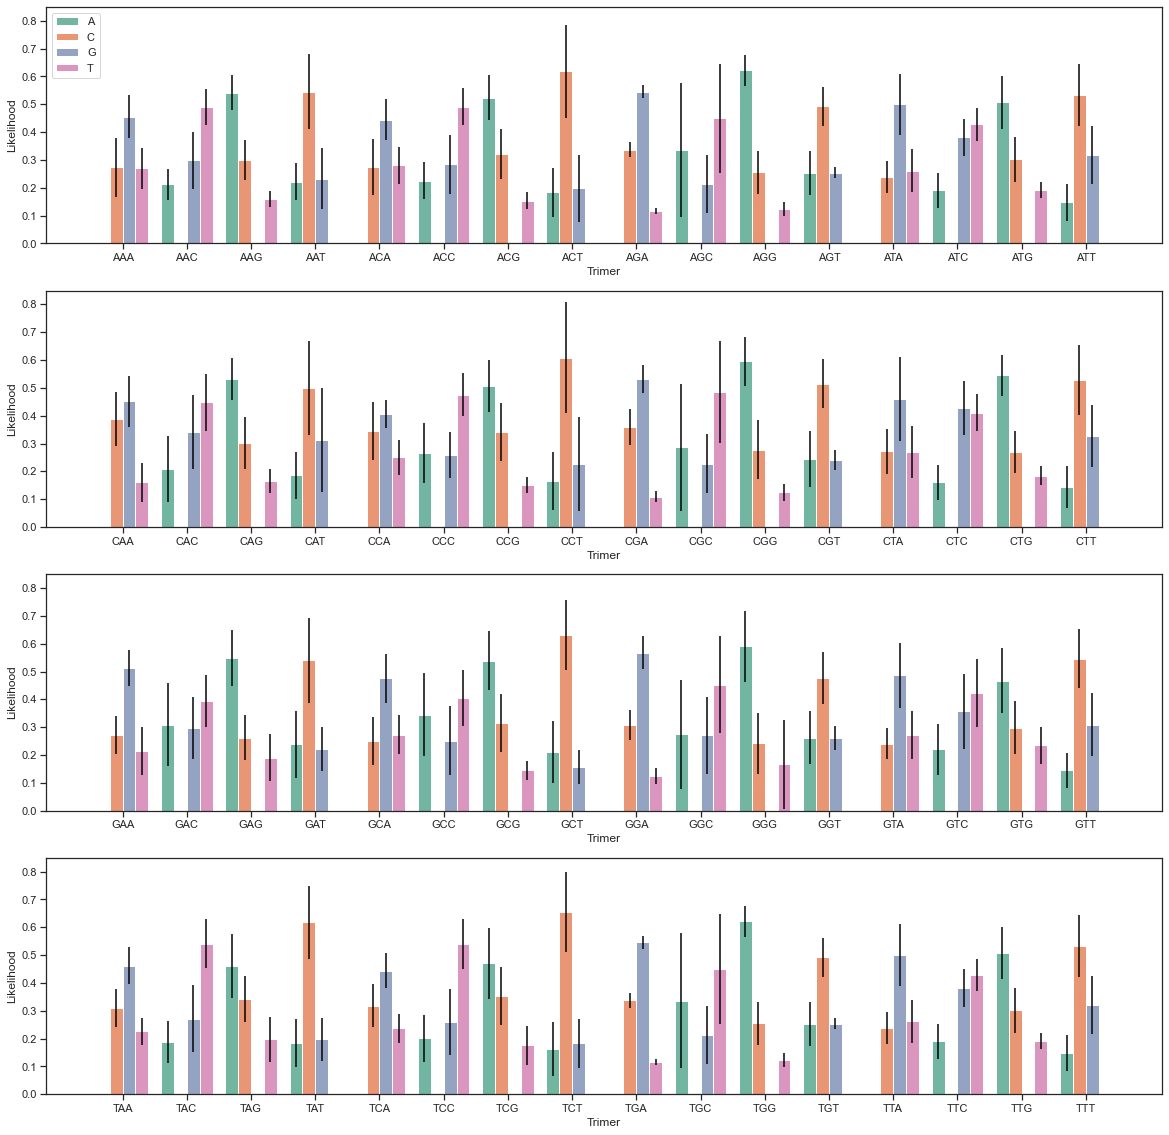

In [10]:
sns.set(style=("ticks"), font_scale=1, palette="Set2")
fig, ax = plt.subplots(4, 1, figsize=(20,20), sharey=True)

for i, df in enumerate(quarter_dataframe(hs5f_trimers_end_melted)):
    
    # dataframe must be sorted first by hue, then by x column to correctly plot errorbars on top of bars
    data = df.sort_values(["Substitution", "Trimer"])
    if i == 0:
        sns.barplot(data=data, x="Trimer", y="Likelihood", hue="Substitution", ax=ax[i])
        ax[i].legend(loc="upper left")
    else:
        sns.barplot(data=data, x="Trimer", y="Likelihood", hue="Substitution", legend=False, ax=ax[i])

    x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax[i].patches]
    y_coords = [p.get_height() for p in ax[i].patches]
    ax[i].errorbar(x=x_coords[:64], y=y_coords[:64], yerr=data["STD"], fmt="none", c="k")
    
    plt.savefig(os.path.dirname(os.path.dirname(os.getcwd())) + "/figs/Aggregated_trimer_substitution_end.png", dpi=300, 
        transparent=True, bbox_inches="tight")

### Concatenate dataframes

In [11]:
hs5f_trimers_center["Position"] = "Center"
hs5f_trimers_start["Position"] = "Start"
hs5f_trimers_end["Position"] = "End"

hs5f_trimers = pd.concat([hs5f_trimers_center, hs5f_trimers_start, hs5f_trimers_end], axis=0)
hs5f_trimers.drop(columns=["A_std", "C_std", "G_std", "T_std"], inplace=True)

print("Number of trimers:", len(hs5f_trimers))
print(hs5f_trimers["Position"].value_counts(dropna=False))
hs5f_trimers[:5]

Number of trimers: 192
Position
Center    64
Start     64
End       64
Name: count, dtype: int64


,Trimer,A,C,G,T,Position
0,AAA,0.000000,0.359430,0.456346,0.184224,Center
1,AAC,0.000000,0.282313,0.492101,0.225586,Center
2,AAG,0.000000,0.308770,0.450100,0.241130,Center
3,AAT,0.000000,0.294574,0.483586,0.221840,Center
4,ACA,0.256514,0.000000,0.306406,0.437080,Center


## Save new substitution matrices

In [12]:
hs5f_trimers.to_csv(data_path + "/HS5F/HS5F_Substitution_trimers.csv", index=False)